In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sainomore import Elissabeth, data
from sainomore.elissabeth import Weighting

In [2]:
x, y = data.long_lookup(1, 25, 5, False)

In [3]:
alpha = 50
config = {
    "context_length" : "25",
    "input_vocab_size" : "5",
    "d_hidden" : "5",
    "n_layers" : "1",
    "layer_norm" : "False",

    "n_is" : "1",
    "length_is" : "2",
    "d_values" : "5",
    "values_2D" : "False",
    "pe_value" : "False",

    "restrict_query_key" : "False",
    "exponent": "1",
    "d_query_key": "3",

    "bias" : "False",

    "share_queries" : "False",
    "share_keys" : "False",
    "share_values" : "False",

    "distance_weighting" : "True",
    "alpha_multiplier" : f"{alpha}",
    "sum_normalization" : "False",
}
model = Elissabeth.build(
    config,
    Weighting.RELATIVE_DISTANCE | Weighting.COSINE,
)

In [4]:
state_dict = model.state_dict()

state_dict["embedding.weight"] = torch.eye(5)
state_dict["layers.0.W_V"] = torch.Tensor([[
    [[1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1]],

    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]]
]]).unsqueeze(-1)

state_dict["layers.0.W_O"] = torch.Tensor([[
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
]]).unsqueeze(2)
state_dict["unembedding.weight"] = torch.eye(5)

state_dict["layers.0.weightings.0.alpha"] = torch.Tensor([[
    [10_000, 0]
]]).unsqueeze(-1).unsqueeze(-1)

d = torch.pi / 2
state_dict["layers.0.weightings.1.W_Q"] = torch.Tensor([[
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
]])
state_dict["layers.0.weightings.1.W_K"] = torch.Tensor([[
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
]])

model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
model.attach_all_hooks()
out = (
    torch.swapaxes(model(x).detach(), 1, 2) - torch.nn.functional.one_hot(x, 5)
)
model.release_all_hooks()

In [6]:
out[:, 1:, :] = out[:, 1:, :] - torch.nn.functional.one_hot(x[:, :-1], 5)
print(x[0, :])
print(out[0, -1])

tensor([1, 2, 3, 4, 1, 3, 3, 4, 0, 3, 0, 0, 1, 3, 3, 1, 0, 1, 0, 0, 3, 0, 0, 1,
        2])
tensor([ 1.5403e-01,  1.0000e+00,  0.0000e+00,  2.4786e-03, -4.4744e-08])


In [7]:
q = model.get_hook("layers.0.weightings.1", "Q").fwd.numpy()
k = model.get_hook("layers.0.weightings.1", "K").fwd.numpy()
v = model.get_hook("layers.0", "V").fwd.numpy()
iss = model.get_hook("layers.0", "iss.2").fwd.numpy()
exid = 0

In [8]:
Q = torch.Tensor(q.squeeze())
K = torch.Tensor(k.squeeze())
V = torch.Tensor(v.squeeze())
print(f"{Q.shape=}, {K.shape=}, {V.shape=}")

Q.shape=torch.Size([25, 2, 3]), K.shape=torch.Size([25, 2, 3]), V.shape=torch.Size([25, 2, 5])


In [9]:
the_result = torch.zeros(25, 5)
for t in range(x.shape[1]):
    for t_2 in range(t):
        for t_1 in range(t_2):
            the_result[t] += (
                  V[t_1, 0]
                * V[t_2, 1]

                * torch.cos(Q[t, 1, 0] - K[t_2, 1, 0])
                * torch.cos(Q[t, 1, 1] - K[t_2, 1, 1])
                * torch.cos(Q[t, 1, 2] - K[t_2, 1, 2])

                * np.exp(-alpha * (t_2 - t_1 - 1)/25)
            )

In [10]:
out

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.1921e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.3534e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.8316e-02,  1.3534e-01,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.4787e-03,  1.8316e-02,  1.3534e-01,  1.0729e-06],
         [ 0.0000e+00,  1.3567e-01,  1.0025e+00,  1.8316e-02,  1.3534e-01],
         [ 0.0000e+00,  1.2711e+00,  1.0028e+00,  2.0793e-02,  1.5365e-01],
         [ 0.0000e+00,  3.6637e-02,  1.3538e-01,  1.1357e+00,  2.4787e-03],
         [ 0.0000e+00,  2.4795e-03,  6.0996e-06,  1.5370e-01,  3.3545e-04],
         [ 1.7881e-06,  1.2714e+00,  1.0028e+00,  1.0416e+00,  2.8903e-01],
         [ 1.3534e-01,  2.5249e-03,  6.2121e-06,  1.5651e-01,  1.0187e+00],
         [ 1.5365e-01,  2.5310e-03,  6.2273e-06,  1.2922e+00,  1.0211e+00],
         [ 1.3781e-01,  2.4796e-03,  1.8316e-02,  1.5370e-01,  1.0003e+00],
         [ 1

In [11]:
the_result

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.9107e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.3711e-08, -8.3519e-23,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -8.0060e-10, -5.9157e-09, -4.3711e-08,  0.0000e+00],
        [ 0.0000e+00,  1.3534e-01,  1.0000e+00,  2.5858e-16,  1.9107e-15],
        [ 0.0000e+00,  1.1357e+00,  1.0025e+00,  1.8316e-02,  1.3534e-01],
        [ 0.0000e+00,  1.8316e-02,  1.3534e-01,  1.0000e+00, -4.3711e-08],
        [ 0.0000e+00, -9.9379e-08, -4.4635e-08, -5.0536e-08, -5.0428e-08],
        [ 0.0000e+00,  1.2711e+00,  1.0028e+00,  1.0208e+00,  1.5365e-01],
        [-4.3711e-08,  2.4795e-03,  6.0996e-06,  1.5370e-01,  1.0003e+00],
        [ 1.3534e-01,  2.5249e-03,  6.2121e-06,  1.1565e+00,  1.0187e+00],
        [-5.0428e-08,  2.4788e-03,  1.8316e-02,  1.3534e-01,  1.0000e+00],
        [ 1.0000e+00,  1.

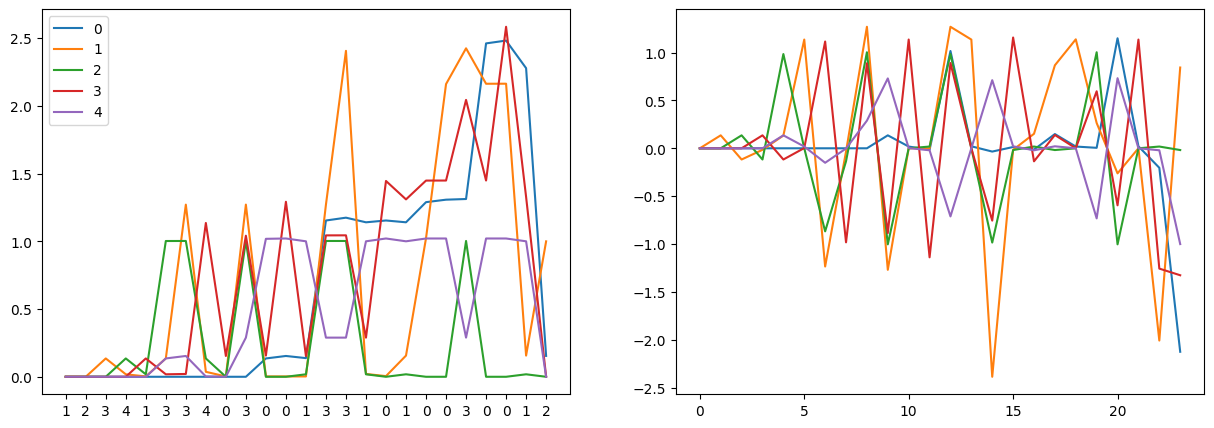

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(5):
    ax[0].plot(out[exid, :, i], label=f"{i}")
    ax[1].plot(out[exid, 1:, i]-out[exid, :-1, i], label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[0].legend()

In [13]:
last_token_increase = np.zeros((x.shape[1], v.shape[-2], ))

for t in range(x.shape[1]):
    for t_2 in range(t+1):
        for t_1 in range(t_2):
            if t == x.shape[1] - 1:
                last_token_increase[t_2] = (
                    np.exp(-alpha*(1/(1+np.exp(-100)))*(t_2-t_1-1)/x.shape[1])
                    * np.cos(q[exid, t, 0, 1, 0] - k[exid, t_2, 0, 1, 0])
                    * np.cos(q[exid, t, 0, 1, 1] - k[exid, t_2, 0, 1, 1])
                    * np.cos(q[exid, t, 0, 1, 2] - k[exid, t_2, 0, 1, 2])
                    * v[exid, t_1, 0, 0, :, 0]
                )


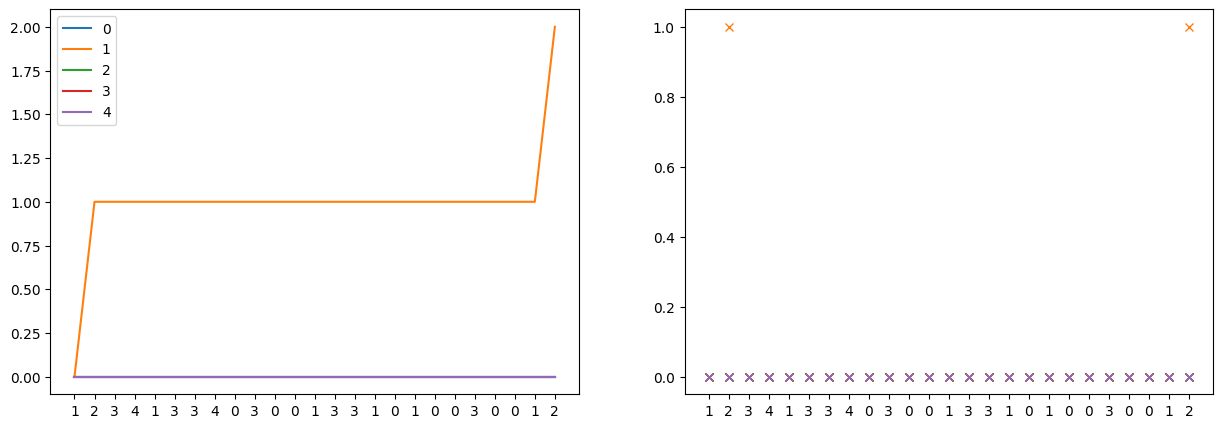

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
last_token_iss = np.cumsum(last_token_increase, axis=0)
for i in range(5):
    ax[0].plot(last_token_iss[:, i], "-", label=f"{i}")
    ax[1].plot(last_token_increase[:, i], "x", label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[1].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[1].set_xticklabels(x[exid].numpy())
ax[0].legend(loc="best")
plt.show()
# ax.set_yscale("log")

In [15]:
y[:, -1] == out.argmax(axis=1)[:, -1]

tensor([False])